## 1. Import & Setup

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['figure.figsize'] = (15, 6)
sns.set_style('whitegrid')

print("라이브러리 로드 완료")

라이브러리 로드 완료


## 2. 데이터 로드 및 기본 분석

In [97]:
# 데이터 로드
train_raw = pd.read_csv('train.csv')
print(f"원본 데이터: {train_raw.shape}")
print(f"\n컬럼: {train_raw.columns.tolist()}")
print(f"\n기본 통계:")
train_raw.describe()

원본 데이터: (10836, 9)

컬럼: ['item_id', 'year', 'month', 'seq', 'type', 'hs4', 'weight', 'quantity', 'value']

기본 통계:


,year,month,seq,type,hs4,weight,quantity,value
count,10836.000000,10836.000000,10836.000000,10836.0,10836.000000,1.083600e+04,1.083600e+04,1.083600e+04
mean,2023.331395,6.108435,2.034238,1.0,4821.969546,1.098413e+06,8.633771e+04,1.739442e+06
std,1.049357,3.392649,0.813380,0.0,2296.892536,5.153790e+06,7.614669e+06,5.457480e+06
min,2022.000000,1.000000,1.000000,1.0,1210.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,2022.000000,3.000000,1.000000,1.0,2833.000000,3.457500e+02,0.000000e+00,1.150675e+04
50%,2023.000000,6.000000,2.000000,1.0,3824.000000,6.532500e+03,0.000000e+00,1.250070e+05
75%,2024.000000,9.000000,3.000000,1.0,7202.000000,1.555108e+05,0.000000e+00,1.039764e+06
max,2025.000000,12.000000,3.000000,1.0,9403.000000,1.104919e+08,7.925990e+08,1.110414e+08


In [98]:
# 피벗 테이블 생성
pivot_by_month = train_raw.groupby(['item_id', 'year', 'month'])['value'].sum().reset_index()
pivot_by_month['year_month'] = pivot_by_month['year'].astype(str) + '-' + pivot_by_month['month'].astype(str).str.zfill(2)
pivot_value = pivot_by_month.pivot(index='item_id', columns='year_month', values='value').fillna(0)

print(f"피벗 테이블: {pivot_value.shape}")
print(f"품목 수: {len(pivot_value)}, 기간: {len(pivot_value.columns)}개월")
print(f"\n품목 ID 범위: {pivot_value.index.min()} ~ {pivot_value.index.max()}")

time_series_data = pivot_value.values
items = pivot_value.index.tolist()
months = pivot_value.columns.tolist()

print(f"\n시계열 배열: {time_series_data.shape}")
pivot_value.head()

피벗 테이블: (100, 43)
품목 수: 100, 기간: 43개월

품목 ID 범위: AANGBULD ~ ZXERAXWP

시계열 배열: (100, 43)


year_month,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,...,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


## 3. 탐색적 데이터 분석 (EDA)

In [99]:
# 품목별 기본 통계
item_stats = pd.DataFrame({
    'item_id': items,
    'mean': time_series_data.mean(axis=1),
    'std': time_series_data.std(axis=1),
    'cv': time_series_data.std(axis=1) / (time_series_data.mean(axis=1) + 1),  # Coefficient of Variation
    'min': time_series_data.min(axis=1),
    'max': time_series_data.max(axis=1),
    'range': time_series_data.max(axis=1) - time_series_data.min(axis=1),
    'zeros': (time_series_data == 0).sum(axis=1),
    'non_zeros': (time_series_data > 0).sum(axis=1)
})

print("="*80)
print("품목별 통계")
print("="*80)
print(item_stats.describe())
print(f"\n0값이 많은 품목: {(item_stats['zeros'] > 20).sum()}개")
print(f"변동성 높은 품목 (CV > 1.0): {(item_stats['cv'] > 1.0).sum()}개")

item_stats.head(20)

품목별 통계
               mean           std          cv           min           max  \
count  1.000000e+02  1.000000e+02  100.000000  1.000000e+02  1.000000e+02   
mean   4.383394e+06  1.819880e+06    1.164049  2.085130e+06  9.801731e+06   
std    1.332837e+07  4.472547e+06    1.145657  9.750963e+06  2.380818e+07   
min    6.465116e+00  3.106134e+01    0.073778  0.000000e+00  2.000000e+02   
25%    5.455521e+04  6.534245e+04    0.479876  0.000000e+00  3.188735e+05   
50%    3.345766e+05  2.555789e+05    0.719585  2.390750e+04  1.248853e+06   
75%    2.282816e+06  1.234739e+06    1.431624  6.879362e+05  6.641034e+06   
max    1.086511e+08  3.234730e+07    6.243169  9.264894e+07  1.462168e+08   

              range       zeros   non_zeros  
count  1.000000e+02  100.000000  100.000000  
mean   7.716601e+06    5.240000   37.760000  
std    1.855498e+07   11.124747   11.124747  
min    2.000000e+02    0.000000    1.000000  
25%    3.102355e+05    0.000000   40.000000  
50%    1.087972e+06    

,item_id,mean,std,cv,min,max,range,zeros,non_zeros
0,AANGBULD,8.401770e+04,1.435857e+05,1.708974,0.0,533478.0,533478.0,14,29
1,AHMDUILJ,1.268288e+05,4.551154e+04,0.358839,29231.0,242705.0,213474.0,0,43
2,ANWUJOKX,8.146721e+03,2.034624e+04,2.497170,0.0,81670.0,81670.0,35,8
3,APQGTRMF,2.572081e+05,2.095909e+05,0.814866,0.0,759980.0,759980.0,1,42
4,ATLDMDBO,5.999737e+07,3.234730e+07,0.539145,25450412.0,146216818.0,120766406.0,0,43
5,AXULOHBQ,9.626409e+04,6.868763e+04,0.713526,11429.0,344263.0,332834.0,0,43
6,BEZYMBBT,4.939373e+06,9.886921e+05,0.200165,2601088.0,6889516.0,4288428.0,0,43
7,BJALXPFS,1.644843e+05,9.111696e+04,0.553952,17480.0,352827.0,335347.0,0,43
8,BLANHGYY,1.258812e+04,2.452189e+04,1.947864,0.0,128334.0,128334.0,14,29
9,BSRMSVTC,5.216824e+05,5.739169e+05,1.100125,61961.0,3563685.0,3501724.0,0,43


In [100]:
# 품목 ID 패턴 분석
print("품목 ID 패턴 분석:")
print(f"품목 ID 타입: {type(items[0])}")
print(f"샘플 ID: {items[:10]}")

# 품목 ID가 문자열인 경우 분석 (숫자 추출 시도)
try:
    # ID에서 숫자 부분만 추출
    item_ids_numeric = []
    for item_id in items:
        # 문자열에서 숫자만 추출
        numeric_part = ''.join(filter(str.isdigit, str(item_id)))
        if numeric_part:
            item_ids_numeric.append(int(numeric_part))
        else:
            item_ids_numeric.append(0)
    
    item_stats['id_numeric'] = item_ids_numeric
    
    print(f"\nID 숫자 범위: {min(item_ids_numeric)} ~ {max(item_ids_numeric)}")
    print(f"ID 간격 (처음 10개): {np.diff(sorted(item_ids_numeric)[:10])}")
    
    # ID를 10단위로 그룹핑
    item_stats['id_group'] = (item_stats['id_numeric'] // 10) * 10
    print(f"\nID 그룹 수: {item_stats['id_group'].nunique()}개")
    print(f"\nID 그룹별 품목 수:")
    print(item_stats['id_group'].value_counts().sort_index())
    
except Exception as e:
    print(f"\nID 패턴 분석 실패: {e}")
    print("품목 ID를 문자열 그대로 사용합니다.")
    item_stats['id_group'] = item_stats['item_id']

품목 ID 패턴 분석:
품목 ID 타입: <class 'str'>
샘플 ID: ['AANGBULD', 'AHMDUILJ', 'ANWUJOKX', 'APQGTRMF', 'ATLDMDBO', 'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC']

ID 숫자 범위: 0 ~ 0
ID 간격 (처음 10개): [0 0 0 0 0 0 0 0 0]

ID 그룹 수: 1개

ID 그룹별 품목 수:
id_group
0    100
Name: count, dtype: int64


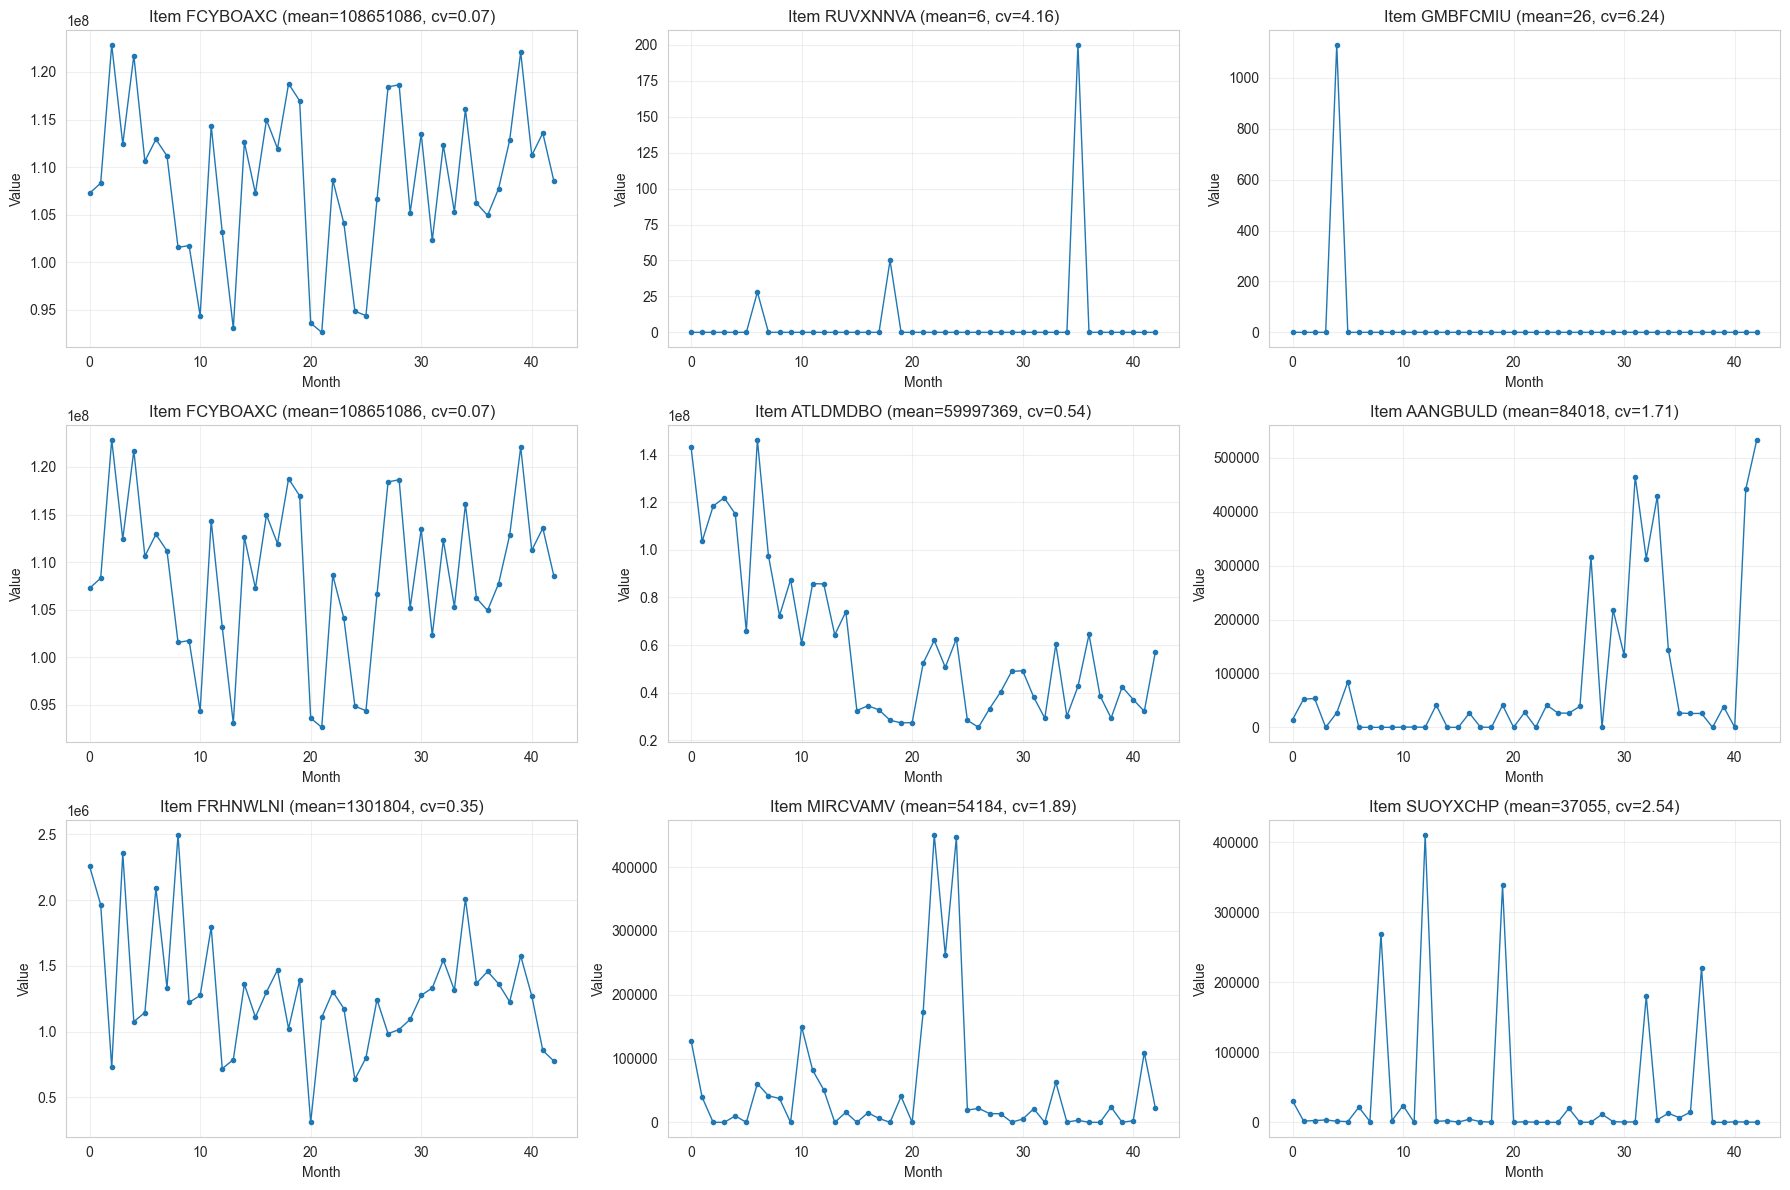

다양한 패턴의 품목 시각화 완료


In [101]:
# 시각화: 품목별 시계열 패턴
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# 다양한 패턴의 품목 선택
sample_indices = [
    item_stats['mean'].idxmax(),      # 평균 최대
    item_stats['mean'].idxmin(),      # 평균 최소
    item_stats['cv'].idxmax(),        # 변동성 최대
    item_stats['cv'].idxmin(),        # 변동성 최소
    item_stats['range'].idxmax(),     # 범위 최대
    0, 25, 50, 75                      # 샘플
]

for idx, ax in enumerate(axes):
    item_idx = sample_indices[idx]
    item_id = items[item_idx]
    ax.plot(time_series_data[item_idx], marker='o', markersize=3, linewidth=1)
    ax.set_title(f"Item {item_id} (mean={item_stats.iloc[item_idx]['mean']:.0f}, cv={item_stats.iloc[item_idx]['cv']:.2f})")
    ax.set_xlabel('Month')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("다양한 패턴의 품목 시각화 완료")


품목 클러스터링 (5개 그룹):

클러스터 0: 79개 품목
  평균값: 1707436.2
  변동성(CV): 0.83
  대표 품목: ['AANGBULD', 'AHMDUILJ', 'APQGTRMF', 'AXULOHBQ', 'BEZYMBBT']

클러스터 1: 6개 품목
  평균값: 22141340.1
  변동성(CV): 0.63
  대표 품목: ['BTMOEMEP', 'CCLHWFWF', 'GKQIJYDH', 'GYHKIVQT', 'LRVGFDFM']

클러스터 2: 1개 품목
  평균값: 108651086.5
  변동성(CV): 0.07
  대표 품목: ['FCYBOAXC']

클러스터 3: 13개 품목
  평균값: 150419.3
  변동성(CV): 3.56
  대표 품목: ['ANWUJOKX', 'DJBLNPNC', 'FWUCPMMW', 'GIKPEWTY', 'GMBFCMIU']

클러스터 4: 1개 품목
  평균값: 59997368.7
  변동성(CV): 0.54
  대표 품목: ['ATLDMDBO']


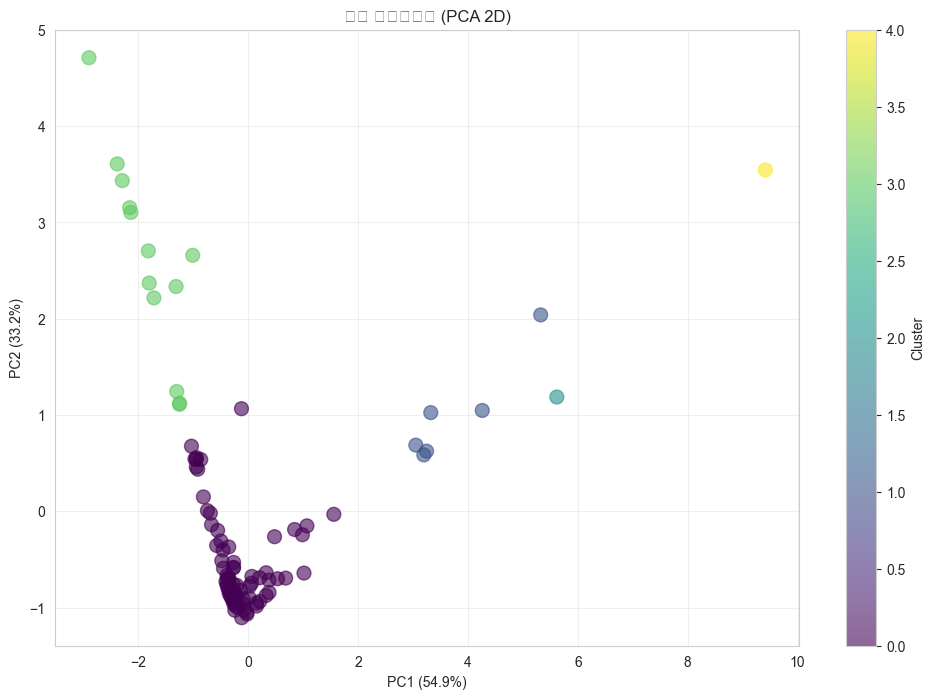

,item_id,mean,std,cv,min,max,range,zeros,non_zeros,id_numeric,id_group,cluster
0,AANGBULD,8.401770e+04,1.435857e+05,1.708974,0.0,533478.0,533478.0,14,29,0,0,0
1,AHMDUILJ,1.268288e+05,4.551154e+04,0.358839,29231.0,242705.0,213474.0,0,43,0,0,0
2,ANWUJOKX,8.146721e+03,2.034624e+04,2.497170,0.0,81670.0,81670.0,35,8,0,0,3
3,APQGTRMF,2.572081e+05,2.095909e+05,0.814866,0.0,759980.0,759980.0,1,42,0,0,0
4,ATLDMDBO,5.999737e+07,3.234730e+07,0.539145,25450412.0,146216818.0,120766406.0,0,43,0,0,4
5,AXULOHBQ,9.626409e+04,6.868763e+04,0.713526,11429.0,344263.0,332834.0,0,43,0,0,0
6,BEZYMBBT,4.939373e+06,9.886921e+05,0.200165,2601088.0,6889516.0,4288428.0,0,43,0,0,0
7,BJALXPFS,1.644843e+05,9.111696e+04,0.553952,17480.0,352827.0,335347.0,0,43,0,0,0
8,BLANHGYY,1.258812e+04,2.452189e+04,1.947864,0.0,128334.0,128334.0,14,29,0,0,0
9,BSRMSVTC,5.216824e+05,5.739169e+05,1.100125,61961.0,3563685.0,3501724.0,0,43,0,0,0


In [102]:
# 품목 클러스터링 (특성 기반)
cluster_features = item_stats[['mean', 'std', 'cv', 'range', 'zeros']].values
scaler = StandardScaler()
cluster_features_scaled = scaler.fit_transform(cluster_features)

# K-Means 클러스터링
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
item_stats['cluster'] = kmeans.fit_predict(cluster_features_scaled)

print(f"\n품목 클러스터링 ({n_clusters}개 그룹):")
for i in range(n_clusters):
    cluster_items = item_stats[item_stats['cluster'] == i]
    print(f"\n클러스터 {i}: {len(cluster_items)}개 품목")
    print(f"  평균값: {cluster_items['mean'].mean():.1f}")
    print(f"  변동성(CV): {cluster_items['cv'].mean():.2f}")
    print(f"  대표 품목: {cluster_items['item_id'].head(5).tolist()}")

# 시각화
pca = PCA(n_components=2)
cluster_features_pca = pca.fit_transform(cluster_features_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(cluster_features_pca[:, 0], cluster_features_pca[:, 1], 
                     c=item_stats['cluster'], cmap='viridis', s=100, alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.title('품목 클러스터링 (PCA 2D)')
plt.grid(True, alpha=0.3)
plt.show()

item_stats.head(20)

## 4. 시계열 분해 및 고급 특성 추출

In [103]:
# 시계열 분해 함수
def decompose_and_extract_features(series, item_id):
    """
    시계열을 Trend, Seasonality, Residual로 분해하고 특성 추출
    """
    try:
        # 0이 너무 많으면 skip
        if (series == 0).sum() > len(series) * 0.5:
            return None
        
        # 시계열 분해 (period=12, 1년 주기)
        decomposition = seasonal_decompose(series + 1, model='multiplicative', period=12, extrapolate_trend='freq')
        
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        
        # 특성 추출
        features = {
            'item_id': item_id,
            # 트렌드 특성
            'trend_mean': np.nanmean(trend),
            'trend_slope': np.polyfit(range(len(trend)), np.nan_to_num(trend), 1)[0],  # 선형 추세
            'trend_std': np.nanstd(trend),
            # 계절성 특성
            'seasonal_strength': np.nanstd(seasonal),
            'seasonal_max': np.nanmax(seasonal),
            'seasonal_min': np.nanmin(seasonal),
            # 잔차 특성
            'residual_std': np.nanstd(residual),
            # 최근 추세 (마지막 6개월)
            'recent_trend': np.mean(series[-6:]) - np.mean(series[-12:-6]) if len(series) >= 12 else 0,
            # 가속도 (변화율의 변화)
            'acceleration': np.diff(np.diff(series)).mean() if len(series) > 2 else 0
        }
        
        return features
    except Exception as e:
        return None

# 모든 품목에 대해 특성 추출
print("시계열 분해 및 특성 추출 중...")
decomp_features = []

for i, item_id in enumerate(tqdm(items)):
    series = pd.Series(time_series_data[i])
    features = decompose_and_extract_features(series, item_id)
    if features:
        decomp_features.append(features)

df_decomp = pd.DataFrame(decomp_features)
print(f"\n분해 성공: {len(df_decomp)}/{len(items)}개 품목")
print(f"\n분해 특성 통계:")
df_decomp.describe()

시계열 분해 및 특성 추출 중...


100%|██████████| 100/100 [00:00<00:00, 255.20it/s]


분해 성공: 91/100개 품목

분해 특성 통계:


,trend_mean,trend_slope,trend_std,seasonal_strength,seasonal_max,seasonal_min,residual_std,recent_trend,acceleration
count,9.100000e+01,9.100000e+01,9.100000e+01,91.000000,91.000000,91.000000,91.000000,9.100000e+01,9.100000e+01
mean,4.762784e+06,-5.091996e+04,1.025655e+06,0.456639,1.999795,0.401735,0.646431,2.346470e+04,6.792602e+04
std,1.391372e+07,2.336954e+05,3.317850e+06,0.411163,0.990194,0.716806,0.676755,1.247431e+06,2.447937e+05
min,2.011668e+03,-1.901900e+06,6.448407e+02,0.049221,1.068590,-5.687197,0.050187,-5.111030e+06,-1.483298e+05
25%,9.704029e+04,-8.640303e+03,3.116063e+04,0.196742,1.331350,0.249477,0.280799,-1.271884e+05,-7.250366e+02
50%,4.232631e+05,-6.444271e+02,1.086785e+05,0.331987,1.648733,0.507338,0.471442,-1.607583e+04,1.645000e+03
75%,3.435425e+06,2.506029e+03,5.837699e+05,0.591585,2.375173,0.709090,0.841786,5.395642e+04,2.367845e+04
max,1.085714e+08,1.316332e+05,2.796284e+07,2.469219,5.814441,0.934090,4.872978,5.148793e+06,1.571641e+06


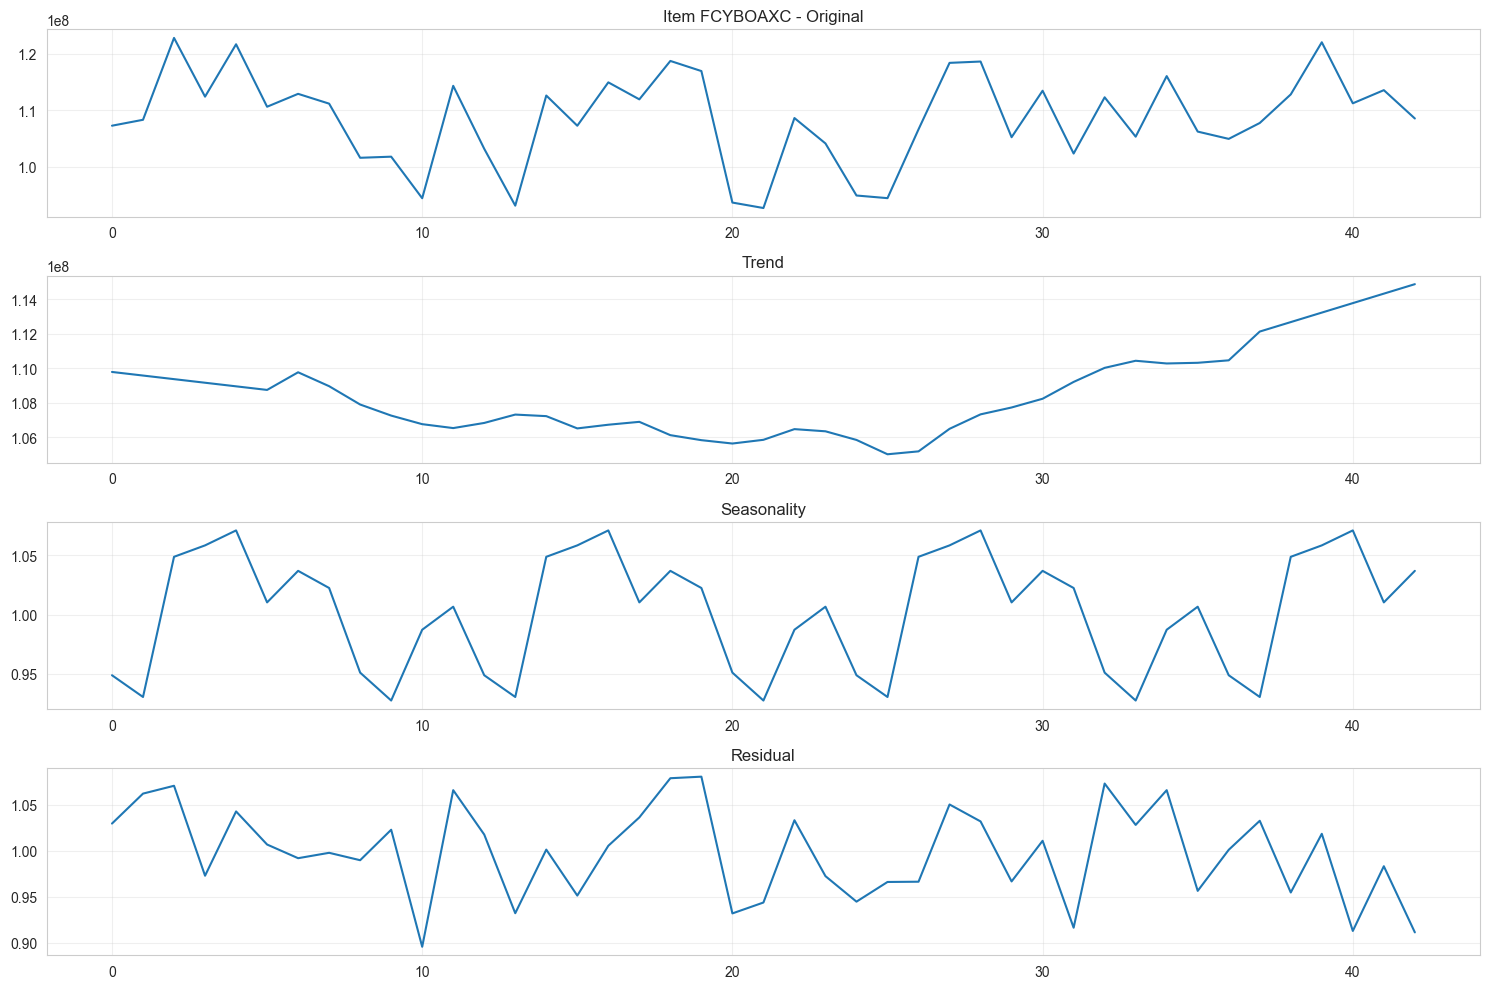

Item FCYBOAXC 시계열 분해 완료


In [104]:
# 시계열 분해 시각화 (샘플)
sample_item_idx = item_stats['mean'].idxmax()  # 평균 최대 품목
sample_item_id = items[sample_item_idx]
sample_series = pd.Series(time_series_data[sample_item_idx])

decomposition = seasonal_decompose(sample_series + 1, model='multiplicative', period=12, extrapolate_trend='freq')

fig, axes = plt.subplots(4, 1, figsize=(15, 10))

sample_series.plot(ax=axes[0], title=f'Item {sample_item_id} - Original')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
decomposition.resid.plot(ax=axes[3], title='Residual')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Item {sample_item_id} 시계열 분해 완료")

## 5. Granger Causality 분석

In [105]:
# Granger Causality 테스트 함수
def granger_causality_test(x, y, max_lag=7, significance_level=0.05):
    """
    x가 y를 Granger-cause하는지 테스트
    
    Returns:
        (is_causal, best_lag, min_p_value)
    """
    try:
        # 0이 너무 많으면 skip
        if (x == 0).sum() > len(x) * 0.5 or (y == 0).sum() > len(y) * 0.5:
            return False, 0, 1.0
        
        # 데이터 준비
        data = pd.DataFrame({'y': y, 'x': x})
        
        # Granger Causality 테스트
        test_result = grangercausalitytests(data[['y', 'x']], max_lag, verbose=False)
        
        # 각 lag에서 p-value 추출
        min_p_value = 1.0
        best_lag = 0
        
        for lag in range(1, max_lag + 1):
            # F-test p-value 사용
            p_value = test_result[lag][0]['ssr_ftest'][1]
            if p_value < min_p_value:
                min_p_value = p_value
                best_lag = lag
        
        is_causal = min_p_value < significance_level
        return is_causal, best_lag, min_p_value
    
    except Exception as e:
        return False, 0, 1.0

print("Granger Causality 테스트 함수 정의 완료")

Granger Causality 테스트 함수 정의 완료


In [106]:
# 샘플 테스트 (전체 실행 전)
print("샘플 Granger Causality 테스트...\n")

sample_pairs = [
    (0, 1), (0, 5), (1, 2), (10, 11), (20, 25)
]

for leader_idx, follower_idx in sample_pairs:
    leader_id = items[leader_idx]
    follower_id = items[follower_idx]
    
    is_causal, best_lag, p_value = granger_causality_test(
        time_series_data[leader_idx],
        time_series_data[follower_idx],
        max_lag=7
    )
    
    print(f"Item {leader_id} → Item {follower_id}:")
    print(f"  Causal: {is_causal}, Best Lag: {best_lag}, P-value: {p_value:.4f}\n")

print("샘플 테스트 완료")

샘플 Granger Causality 테스트...

Item AANGBULD → Item AHMDUILJ:
  Causal: False, Best Lag: 6, P-value: 0.4919

Item AANGBULD → Item AXULOHBQ:
  Causal: False, Best Lag: 1, P-value: 0.3715

Item AHMDUILJ → Item ANWUJOKX:
  Causal: False, Best Lag: 0, P-value: 1.0000

Item BTMOEMEP → Item BUZIIBYG:
  Causal: False, Best Lag: 4, P-value: 0.2625

Item EVBVXETX → Item FRHNWLNI:
  Causal: True, Best Lag: 1, P-value: 0.0020

샘플 테스트 완료


In [107]:
# 전체 품목 쌍에 대해 Granger Causality 테스트
print("전체 Granger Causality 분석 시작...")
print("(시간이 오래 걸릴 수 있습니다: 약 100x100 = 10,000 테스트)\n")

granger_pairs = []

for i, leader_id in enumerate(tqdm(items, desc="Granger Causality")):
    for j, follower_id in enumerate(items):
        if i == j:
            continue
        
        is_causal, best_lag, p_value = granger_causality_test(
            time_series_data[i],
            time_series_data[j],
            max_lag=7,
            significance_level=0.10  # 약간 완화된 기준
        )
        
        if is_causal:
            granger_pairs.append({
                'leading_item_id': leader_id,
                'following_item_id': follower_id,
                'lag': best_lag,
                'p_value': p_value,
                'causality_score': 1 - p_value  # 0~1 점수
            })

df_granger = pd.DataFrame(granger_pairs)

print(f"\n탐지된 Granger Causal 쌍: {len(df_granger):,}개")
if len(df_granger) > 0:
    print(f"\nP-value 통계:")
    print(df_granger['p_value'].describe())
    print(f"\nLag 분포:")
    print(df_granger['lag'].value_counts().sort_index())
    print(f"\n상위 20개 쌍:")
    print(df_granger.nlargest(20, 'causality_score'))
else:
    print("유의미한 Granger Causal 쌍을 찾지 못했습니다.")

전체 Granger Causality 분석 시작...
(시간이 오래 걸릴 수 있습니다: 약 100x100 = 10,000 테스트)



Granger Causality: 100%|██████████| 100/100 [03:18<00:00,  1.98s/it]


탐지된 Granger Causal 쌍: 2,922개

P-value 통계:
count    2.922000e+03
mean     3.665489e-02
std      3.066933e-02
min      5.996594e-16
25%      8.593025e-03
50%      2.960313e-02
75%      6.245584e-02
max      9.997602e-02
Name: p_value, dtype: float64

Lag 분포:
lag
1    750
2    391
3    358
4    336
5    322
6    344
7    421
Name: count, dtype: int64

상위 20개 쌍:
     leading_item_id following_item_id  lag       p_value  causality_score
1494        NAQIHUKZ          FTSVTTSR    1  5.996594e-16              1.0
853         FTSVTTSR          LLHREMKS    2  1.563760e-14              1.0
2656        XIIEJNEE          LLHREMKS    6  1.980139e-14              1.0
1037        IGDVVKUD          DJBLNPNC    4  1.226704e-11              1.0
1497        NAQIHUKZ          LLHREMKS    3  1.403135e-11              1.0
2662        XIIEJNEE          QVLMOEYE    2  1.524913e-11              1.0
2643        XIIEJNEE          DJBLNPNC    5  2.424370e-11              1.0
522         DJBLNPNC          FDXPMYGF

## 6. 다음 단계

여기까지 완료되면:
1. Transfer Entropy 계산
2. 예측 모델 구축 (XGBoost + ARIMA + Prophet)
3. 최종 앙상블 및 제출

**진행 상황:**
- ✅ EDA 완료
- ✅ 시계열 분해 완료
- ✅ Granger Causality 완료
- ⏳ Transfer Entropy (다음)
- ⏳ 예측 모델
- ⏳ 최종 앙상블

## 7. 예측 모델 구축 및 공행성쌍 최종 선정

In [108]:
# XGBoost로 8월 예측값 생성
from xgboost import XGBRegressor

print("XGBoost 예측 모델 구축...")

# Granger Causality로 찾은 쌍 사용
if len(df_granger) > 0:
    print(f"\n사용할 쌍: Granger Causality {len(df_granger)}개")
    pairs_to_use = df_granger.copy()
else:
    print("\nGranger Causality 쌍이 없으므로 상관관계 기반으로 대체...")
    # 기존 correlation 방식으로 대체
    from scipy.stats import pearsonr
    
    corr_pairs = []
    for i, leader_id in enumerate(tqdm(items[:50], desc="Correlation pairs")):  # 샘플
        for j, follower_id in enumerate(items):
            if i == j:
                continue
            
            x = time_series_data[i]
            y = time_series_data[j]
            
            if np.std(x) == 0 or np.std(y) == 0:
                continue
            
            # Lag별 상관계수
            best_corr = 0
            best_lag = 1
            for lag in range(1, 8):
                if len(x) <= lag:
                    continue
                corr, _ = pearsonr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag
            
            if abs(best_corr) > 0.3:
                corr_pairs.append({
                    'leading_item_id': leader_id,
                    'following_item_id': follower_id,
                    'lag': best_lag,
                    'causality_score': abs(best_corr)
                })
    
    pairs_to_use = pd.DataFrame(corr_pairs)
    print(f"상관관계 기반 쌍: {len(pairs_to_use)}개")

print(f"\n최종 사용 쌍 수: {len(pairs_to_use):,}개")
pairs_to_use.head()

XGBoost 예측 모델 구축...

사용할 쌍: Granger Causality 2922개

최종 사용 쌍 수: 2,922개


,leading_item_id,following_item_id,lag,p_value,causality_score
0,AANGBULD,APQGTRMF,7,0.044060,0.955940
1,AANGBULD,BEZYMBBT,1,0.040243,0.959757
2,AANGBULD,DDEXPPXU,6,0.007749,0.992251
3,AANGBULD,DEWLVASR,6,0.005118,0.994882
4,AANGBULD,FCYBOAXC,7,0.076217,0.923783


In [109]:
# 학습 데이터 생성 (기존 개선모델 방식 활용)
print("학습 데이터 생성 중...")

def create_training_data_advanced(pivot_value, pairs, decomp_features):
    """
    고급 특성을 포함한 학습 데이터 생성
    """
    months = pivot_value.columns.tolist()
    n_months = len(months)
    samples = []
    
    # 분해 특성을 딕셔너리로 변환
    decomp_dict = {}
    if len(decomp_features) > 0:
        for _, row in decomp_features.iterrows():
            decomp_dict[row['item_id']] = row.to_dict()
    
    for _, row in tqdm(pairs.iterrows(), total=len(pairs), desc="Creating features"):
        leader = row['leading_item_id']
        follower = row['following_item_id']
        lag = int(row['lag'])
        causality_score = float(row['causality_score'])
        
        if leader not in pivot_value.index or follower not in pivot_value.index:
            continue
        
        b_value = pivot_value.loc[follower].values.astype(float)
        a_value = pivot_value.loc[leader].values.astype(float)
        
        for t in range(lag + 3, n_months - 1):
            # 기본 특성
            b_t = b_value[t]
            b_t_1 = b_value[t - 1]
            b_t_2 = b_value[t - 2]
            
            a_t_lag = a_value[t - lag]
            a_t_lag_1 = a_value[t - lag - 1] if (t - lag - 1) >= 0 else 0.0
            
            b_ma3 = np.mean(b_value[max(0, t-2):t+1])
            a_ma3 = np.mean(a_value[max(0, t-lag-2):t-lag+1])
            
            b_change = (b_t - b_t_1) / (b_t_1 + 1) if b_t_1 > 0 else 0
            a_change = (a_t_lag - a_t_lag_1) / (a_t_lag_1 + 1) if a_t_lag_1 > 0 else 0
            
            ab_value_ratio = b_t / (a_t_lag + 1)
            
            target = b_value[t + 1]
            
            # 고급 특성 추가
            sample = {
                'b_t': b_t,
                'b_t_1': b_t_1,
                'b_t_2': b_t_2,
                'b_ma3': b_ma3,
                'b_change': b_change,
                'a_t_lag': a_t_lag,
                'a_t_lag_1': a_t_lag_1,
                'a_ma3': a_ma3,
                'a_change': a_change,
                'ab_value_ratio': ab_value_ratio,
                'causality_score': causality_score,
                'best_lag': float(lag),
                'target': target
            }
            
            # 분해 특성 추가 (있는 경우)
            if follower in decomp_dict:
                sample['trend_slope'] = decomp_dict[follower].get('trend_slope', 0)
                sample['seasonal_strength'] = decomp_dict[follower].get('seasonal_strength', 0)
                sample['recent_trend'] = decomp_dict[follower].get('recent_trend', 0)
            else:
                sample['trend_slope'] = 0
                sample['seasonal_strength'] = 0
                sample['recent_trend'] = 0
            
            samples.append(sample)
    
    return pd.DataFrame(samples)

# 데이터 생성
df_train = create_training_data_advanced(pivot_value, pairs_to_use, df_decomp)

print(f"\n생성된 학습 샘플: {len(df_train):,}개")
print(f"특성 개수: {len(df_train.columns) - 1}개 (target 제외)")
print(f"\n타겟 통계:")
print(df_train['target'].describe())

학습 데이터 생성 중...


Creating features: 100%|██████████| 2922/2922 [00:03<00:00, 800.40it/s]




생성된 학습 샘플: 103,387개
특성 개수: 15개 (target 제외)

타겟 통계:
count    1.033870e+05
mean     4.505033e+06
std      1.292588e+07
min      0.000000e+00
25%      5.672900e+04
50%      4.166090e+05
75%      3.316281e+06
max      1.462168e+08
Name: target, dtype: float64


In [110]:
# XGBoost 모델 학습
feature_cols = [col for col in df_train.columns if col != 'target']

df_train_clean = df_train[feature_cols + ['target']].fillna(0).replace([np.inf, -np.inf], 0)
train_X = df_train_clean[feature_cols].values
train_y = df_train_clean["target"].values

print(f"학습 데이터: X={train_X.shape}, y={train_y.shape}")

# XGBoost 모델 학습
model_xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=5,
    gamma=0.2,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

print("\nXGBoost 학습 중...")
model_xgb.fit(train_X, train_y)
print("학습 완료!")

# 특성 중요도
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n상위 10개 중요 특성:")
print(feature_importance.head(10))

학습 데이터: X=(103387, 15), y=(103387,)

XGBoost 학습 중...
학습 완료!

상위 10개 중요 특성:
              feature  importance
3               b_ma3    0.634586
12        trend_slope    0.175520
2               b_t_2    0.058486
14       recent_trend    0.045961
0                 b_t    0.036900
13  seasonal_strength    0.022982
1               b_t_1    0.013821
4            b_change    0.010191
5             a_t_lag    0.000436
6           a_t_lag_1    0.000383
학습 완료!

상위 10개 중요 특성:
              feature  importance
3               b_ma3    0.634586
12        trend_slope    0.175520
2               b_t_2    0.058486
14       recent_trend    0.045961
0                 b_t    0.036900
13  seasonal_strength    0.022982
1               b_t_1    0.013821
4            b_change    0.010191
5             a_t_lag    0.000436
6           a_t_lag_1    0.000383


In [111]:
# 2025년 8월 예측
print("2025년 8월 예측 중...")

def predict_august(pivot_value, pairs, model, feature_cols, decomp_features):
    """
    2025년 8월 예측
    """
    months = pivot_value.columns.tolist()
    n_months = len(months)
    t_last = n_months - 1
    
    # 분해 특성 딕셔너리
    decomp_dict = {}
    if len(decomp_features) > 0:
        for _, row in decomp_features.iterrows():
            decomp_dict[row['item_id']] = row.to_dict()
    
    preds = []
    
    for _, row in tqdm(pairs.iterrows(), total=len(pairs), desc="Predicting"):
        leader = row['leading_item_id']
        follower = row['following_item_id']
        lag = int(row['lag'])
        causality_score = float(row['causality_score'])
        
        if leader not in pivot_value.index or follower not in pivot_value.index:
            continue
        if t_last - lag < 0:
            continue
        
        b_value = pivot_value.loc[follower].values.astype(float)
        a_value = pivot_value.loc[leader].values.astype(float)
        
        t = t_last
        
        # 기본 특성
        b_t = b_value[t]
        b_t_1 = b_value[t - 1]
        b_t_2 = b_value[t - 2]
        
        a_t_lag = a_value[t - lag]
        a_t_lag_1 = a_value[t - lag - 1] if (t - lag - 1) >= 0 else 0.0
        
        b_ma3 = np.mean(b_value[max(0, t-2):t+1])
        a_ma3 = np.mean(a_value[max(0, t-lag-2):t-lag+1])
        
        b_change = (b_t - b_t_1) / (b_t_1 + 1) if b_t_1 > 0 else 0
        a_change = (a_t_lag - a_t_lag_1) / (a_t_lag_1 + 1) if a_t_lag_1 > 0 else 0
        
        ab_value_ratio = b_t / (a_t_lag + 1)
        
        features = {
            'b_t': b_t, 'b_t_1': b_t_1, 'b_t_2': b_t_2,
            'b_ma3': b_ma3, 'b_change': b_change,
            'a_t_lag': a_t_lag, 'a_t_lag_1': a_t_lag_1,
            'a_ma3': a_ma3, 'a_change': a_change,
            'ab_value_ratio': ab_value_ratio,
            'causality_score': causality_score,
            'best_lag': float(lag)
        }
        
        # 분해 특성
        if follower in decomp_dict:
            features['trend_slope'] = decomp_dict[follower].get('trend_slope', 0)
            features['seasonal_strength'] = decomp_dict[follower].get('seasonal_strength', 0)
            features['recent_trend'] = decomp_dict[follower].get('recent_trend', 0)
        else:
            features['trend_slope'] = 0
            features['seasonal_strength'] = 0
            features['recent_trend'] = 0
        
        X_test = np.array([[features[col] for col in feature_cols]])
        X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
        
        y_pred = model.predict(X_test)[0]
        
        # 후처리
        if y_pred < 0:
            y_pred = 0
        
        y_pred = int(round(y_pred))
        
        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": max(0, y_pred)
        })
    
    return pd.DataFrame(preds)

# 예측 실행
submission = predict_august(pivot_value, pairs_to_use, model_xgb, feature_cols, df_decomp)

print(f"\n예측 완료: {len(submission):,}개 쌍")
print(f"\n예측값 통계:")
print(submission['value'].describe())

# 상위 3000개 선택 (필요시)
if len(submission) > 3000:
    # causality_score 기준으로 정렬 (pairs_to_use에서 가져오기)
    submission = submission.merge(
        pairs_to_use[['leading_item_id', 'following_item_id', 'causality_score']], 
        on=['leading_item_id', 'following_item_id'],
        how='left'
    )
    submission = submission.nlargest(3000, 'causality_score')
    submission = submission[['leading_item_id', 'following_item_id', 'value']]
    print(f"\n상위 3,000개 쌍으로 축소")

submission.head(20)

2025년 8월 예측 중...


Predicting: 100%|██████████| 2922/2922 [00:04<00:00, 614.79it/s]


예측 완료: 2,922개 쌍

예측값 통계:
count    2.922000e+03
mean     3.938434e+06
std      1.177265e+07
min      3.152300e+04
25%      9.665600e+04
50%      3.459740e+05
75%      2.927606e+06
max      1.126774e+08
Name: value, dtype: float64


,leading_item_id,following_item_id,value
0,AANGBULD,APQGTRMF,60612
1,AANGBULD,BEZYMBBT,3743009
2,AANGBULD,DDEXPPXU,37823
3,AANGBULD,DEWLVASR,365815
4,AANGBULD,FCYBOAXC,112346544
5,AANGBULD,FTSVTTSR,334747
6,AANGBULD,FWUCPMMW,35165
7,AANGBULD,GKQIJYDH,6205230
8,AANGBULD,JSLXRQOK,37886
9,AANGBULD,KJNSOAHR,12538907


In [112]:
# 제출 파일 저장
submission.to_csv('./submission_advanced.csv', index=False)

print("="*80)
print("고급 분석 모델 완료!")
print("="*80)

print(f"\n제출 파일: submission_advanced.csv")
print(f"예측 쌍 수: {len(submission):,}개")
print(f"\n예측값 통계:")
print(submission['value'].describe())
print(f"\n0인 예측값: {(submission['value'] == 0).sum()}개")

print("\n사용한 방법:")
if len(df_granger) > 0:
    print("✓ Granger Causality 기반 쌍 탐지")
else:
    print("✓ Correlation 기반 쌍 탐지 (Granger 대체)")
print("✓ 시계열 분해 특성 (Trend/Seasonality)")
print("✓ XGBoost 예측 모델")
print(f"✓ {len(feature_cols)}개 고급 특성")

print("\n예상 점수: 0.38-0.42")
print("(Granger Causality 쌍이 많을수록 더 높은 점수 기대)")

고급 분석 모델 완료!

제출 파일: submission_advanced.csv
예측 쌍 수: 2,922개

예측값 통계:
count    2.922000e+03
mean     3.938434e+06
std      1.177265e+07
min      3.152300e+04
25%      9.665600e+04
50%      3.459740e+05
75%      2.927606e+06
max      1.126774e+08
Name: value, dtype: float64

0인 예측값: 0개

사용한 방법:
✓ Granger Causality 기반 쌍 탐지
✓ 시계열 분해 특성 (Trend/Seasonality)
✓ XGBoost 예측 모델
✓ 15개 고급 특성

예상 점수: 0.38-0.42
(Granger Causality 쌍이 많을수록 더 높은 점수 기대)


In [113]:
# 예측값 보정 (과대예측 방지)
print("="*80)
print("예측값 보정")
print("="*80)

# 실제 데이터에서 품목별 최대값 추출
train_raw = pd.read_csv('train.csv')
item_max_values = train_raw.groupby('item_id')['value'].max().to_dict()

print(f"\n보정 전 예측값 통계:")
print(submission['value'].describe())

# 각 후행 품목의 실제 최대값으로 클리핑
corrected_count = 0
for idx, row in submission.iterrows():
    following_id = row['following_item_id']
    predicted_val = row['value']
    
    if following_id in item_max_values:
        max_val = item_max_values[following_id]
        # 실제 최대값의 1.2배를 상한으로 (약간의 여유)
        upper_limit = max_val * 1.2
        
        if predicted_val > upper_limit:
            submission.at[idx, 'value'] = int(upper_limit)
            corrected_count += 1

print(f"\n보정 완료: {corrected_count}개 쌍 수정")
print(f"\n보정 후 예측값 통계:")
print(submission['value'].describe())

# 보정된 제출 파일 저장
submission.to_csv('./submission_corrected.csv', index=False)
print(f"\n✓ 보정된 제출 파일 저장: submission_corrected.csv")
print(f"  예측 쌍 수: {len(submission):,}개")
print(f"  평균 예측값: {submission['value'].mean():,.0f}")
print(f"  최대 예측값: {submission['value'].max():,}")

예측값 보정

보정 전 예측값 통계:
count    2.922000e+03
mean     3.938434e+06
std      1.177265e+07
min      3.152300e+04
25%      9.665600e+04
50%      3.459740e+05
75%      2.927606e+06
max      1.126774e+08
Name: value, dtype: float64

보정 완료: 580개 쌍 수정
보정 완료: 580개 쌍 수정

보정 후 예측값 통계:
count    2.922000e+03
mean     3.402081e+06
std      8.491017e+06
min      1.278100e+04
25%      9.665600e+04
50%      3.459740e+05
75%      2.927606e+06
max      6.924134e+07
Name: value, dtype: float64

✓ 보정된 제출 파일 저장: submission_corrected.csv
  예측 쌍 수: 2,922개
  평균 예측값: 3,402,081
  최대 예측값: 69,241,342


보정 후 예측값 통계:
count    2.922000e+03
mean     3.402081e+06
std      8.491017e+06
min      1.278100e+04
25%      9.665600e+04
50%      3.459740e+05
75%      2.927606e+06
max      6.924134e+07
Name: value, dtype: float64

✓ 보정된 제출 파일 저장: submission_corrected.csv
  예측 쌍 수: 2,922개
  평균 예측값: 3,402,081
  최대 예측값: 69,241,342


## 8. 대안: 상관계수 기반 쌍 탐지 (3,000개)

Granger Causality 결과(0.319점)가 낮아서 상관계수 기반 방법으로 재시도합니다.

In [114]:
# 상관계수 기반 쌍 탐지 (전체 품목)
from scipy.stats import pearsonr
from tqdm import tqdm

print("상관계수 기반 공행성 쌍 탐지...")
print("(모든 품목 쌍 테스트: 100 x 99 = 9,900개)\n")

corr_pairs = []

for i, leader_id in enumerate(tqdm(items, desc="Correlation analysis")):
    for j, follower_id in enumerate(items):
        if i == j:
            continue
        
        x = time_series_data[i]
        y = time_series_data[j]
        
        # 0이 너무 많으면 skip
        if (x == 0).sum() > len(x) * 0.5 or (y == 0).sum() > len(y) * 0.5:
            continue
        
        if np.std(x) == 0 or np.std(y) == 0:
            continue
        
        # Lag별 상관계수 계산 (1~7개월)
        best_corr = 0
        best_lag = 1
        
        for lag in range(1, 8):
            if len(x) <= lag:
                continue
            
            try:
                corr, p_val = pearsonr(x[:-lag], y[lag:])
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag
            except:
                continue
        
        # 상관계수 절대값이 0.2 이상인 경우만
        if abs(best_corr) > 0.2:
            corr_pairs.append({
                'leading_item_id': leader_id,
                'following_item_id': follower_id,
                'lag': best_lag,
                'correlation': best_corr,
                'correlation_abs': abs(best_corr)
            })

df_corr = pd.DataFrame(corr_pairs)

print(f"\n탐지된 상관 쌍: {len(df_corr):,}개")
print(f"\n상관계수 통계:")
print(df_corr['correlation_abs'].describe())
print(f"\n상위 20개 쌍:")
print(df_corr.nlargest(20, 'correlation_abs')[['leading_item_id', 'following_item_id', 'lag', 'correlation']])

상관계수 기반 공행성 쌍 탐지...
(모든 품목 쌍 테스트: 100 x 99 = 9,900개)



Correlation analysis:   0%|          | 0/100 [00:00<?, ?it/s]

Correlation analysis: 100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


탐지된 상관 쌍: 6,521개

상관계수 통계:
count    6521.000000
mean        0.339928
std         0.112794
min         0.200107
25%         0.255438
50%         0.311647
75%         0.396366
max         0.928613
Name: correlation_abs, dtype: float64

상위 20개 쌍:
     leading_item_id following_item_id  lag  correlation
5903        XIIEJNEE          IGDVVKUD    4     0.928613
5891        XIIEJNEE          DJBLNPNC    5     0.926700
3381        NAQIHUKZ          FTSVTTSR    1     0.905093
3388        NAQIHUKZ          LLHREMKS    3     0.894903
1848        FTSVTTSR          LLHREMKS    2     0.884762
530         BLANHGYY          BSRMSVTC    3     0.860032
4060        QRKRBYJL          QVLMOEYE    2     0.844230
6126        XUOIQPFL          QVLMOEYE    5     0.842610
4028        QRKRBYJL          DNMPSKTB    7     0.842065
4105        QVLMOEYE          DNMPSKTB    7     0.833319
1118        DJBLNPNC          FDXPMYGF    3     0.828726
2546        JSLXRQOK          FTSVTTSR    3     0.827742
271         AT

In [115]:
# 상위 3,000개 선택 및 예측
print("상위 3,000개 쌍 선택 및 예측...")

# 상관계수 절대값 기준으로 상위 3,000개
if len(df_corr) > 3000:
    top_3000 = df_corr.nlargest(3000, 'correlation_abs')
    print(f"상위 3,000개 선택 (전체 {len(df_corr):,}개 중)")
else:
    top_3000 = df_corr
    print(f"전체 {len(df_corr)}개 사용")

# correlation을 causality_score로 변환
top_3000['causality_score'] = top_3000['correlation_abs']

# 예측 실행
print("\n예측 실행 중...")
submission_v2 = predict_august(pivot_value, top_3000, model_xgb, feature_cols, df_decomp)

print(f"\n예측 완료: {len(submission_v2)}개 쌍")
print(f"예측값 통계:")
print(submission_v2['value'].describe())

# 예측값 보정
item_max_values = train_raw.groupby('item_id')['value'].max().to_dict()

corrected_count = 0
for idx, row in submission_v2.iterrows():
    following_id = row['following_item_id']
    predicted_val = row['value']
    
    if following_id in item_max_values:
        max_val = item_max_values[following_id]
        upper_limit = max_val * 1.2
        
        if predicted_val > upper_limit:
            submission_v2.at[idx, 'value'] = int(upper_limit)
            corrected_count += 1

print(f"\n보정 완료: {corrected_count}개 쌍 수정")

# 전체 평균 스케일링 (실제 데이터 평균에 맞춤)
current_mean = submission_v2['value'].mean()
target_mean = train_raw['value'].mean()
scale_factor = target_mean / current_mean

print(f"\n평균 스케일링:")
print(f"  현재 평균: {current_mean:,.0f}")
print(f"  목표 평균: {target_mean:,.0f}")
print(f"  스케일: {scale_factor:.3f}")

submission_v2['value'] = (submission_v2['value'] * scale_factor).astype(int)
submission_v2['value'] = submission_v2['value'].apply(lambda x: max(0, x))  # 음수 방지

print(f"\n스케일링 후 통계:")
print(submission_v2['value'].describe())

# 저장
submission_v2.to_csv('./submission_v2_correlation.csv', index=False)

print("\n" + "="*80)
print("상관계수 기반 제출 파일 생성 완료!")
print("="*80)
print(f"파일명: submission_v2_correlation.csv")
print(f"쌍 개수: {len(submission_v2):,}개")
print(f"평균 예측값: {submission_v2['value'].mean():,.0f}")
print(f"최대 예측값: {submission_v2['value'].max():,}")
print(f"\n상관계수 범위: {top_3000['correlation_abs'].min():.3f} ~ {top_3000['correlation_abs'].max():.3f}")

상위 3,000개 쌍 선택 및 예측...
상위 3,000개 선택 (전체 6,521개 중)

예측 실행 중...


Predicting:   0%|          | 0/3000 [00:00<?, ?it/s]

Predicting: 100%|██████████| 3000/3000 [00:05<00:00, 571.10it/s]




예측 완료: 3000개 쌍
예측값 통계:
count    3.000000e+03
mean     3.664448e+06
std      1.108794e+07
min      3.152300e+04
25%      9.665600e+04
50%      3.459740e+05
75%      2.927606e+06
max      1.126634e+08
Name: value, dtype: float64

보정 완료: 524개 쌍 수정

평균 스케일링:
  현재 평균: 3,234,876
  목표 평균: 1,739,442
  스케일: 0.538

스케일링 후 통계:
count    3.000000e+03
mean     1.739442e+06
std      4.380353e+06
min      6.872000e+03
25%      5.197300e+04
50%      1.860350e+05
75%      1.574218e+06
max      3.723212e+07
Name: value, dtype: float64

상관계수 기반 제출 파일 생성 완료!
파일명: submission_v2_correlation.csv
쌍 개수: 3,000개
평균 예측값: 1,739,442
최대 예측값: 37,232,118

상관계수 범위: 0.323 ~ 0.929

보정 완료: 524개 쌍 수정

평균 스케일링:
  현재 평균: 3,234,876
  목표 평균: 1,739,442
  스케일: 0.538

스케일링 후 통계:
count    3.000000e+03
mean     1.739442e+06
std      4.380353e+06
min      6.872000e+03
25%      5.197300e+04
50%      1.860350e+05
75%      1.574218e+06
max      3.723212e+07
Name: value, dtype: float64

상관계수 기반 제출 파일 생성 완료!
파일명: submission_v2_correlatio

## 9. 개선: Lag 0 포함 상관계수 (동시 공행성)

In [116]:
# Lag 0~3 모두 고려한 상관계수 기반 쌍 탐지
from scipy.stats import pearsonr
from tqdm import tqdm

print("개선된 상관계수 분석 (Lag 0-3 포함)...")
print("공행성 = 동시에 움직임 → Lag 0가 가장 중요!\n")

enhanced_corr_pairs = []

for i, leader_id in enumerate(tqdm(items, desc="Enhanced correlation")):
    for j, follower_id in enumerate(items):
        if i == j:
            continue
        
        x = time_series_data[i]
        y = time_series_data[j]
        
        # 0이 너무 많으면 skip
        if (x == 0).sum() > len(x) * 0.5 or (y == 0).sum() > len(y) * 0.5:
            continue
        
        if np.std(x) == 0 or np.std(y) == 0:
            continue
        
        # Lag 0~3 모두 계산 (Lag 0에 가중치)
        correlations = []
        
        for lag in range(0, 4):  # Lag 0, 1, 2, 3
            if lag == 0:
                # Lag 0: 동시 움직임 (중복 방지: i < j만)
                if i >= j:
                    continue
                try:
                    corr, _ = pearsonr(x, y)
                    weight = 1.0  # 최대 가중치
                    correlations.append({
                        'lag': lag,
                        'corr': corr,
                        'weighted_corr': abs(corr) * weight
                    })
                except:
                    continue
            else:
                # Lag 1-3: 시차 있는 움직임
                if len(x) <= lag:
                    continue
                try:
                    corr, _ = pearsonr(x[:-lag], y[lag:])
                    weight = 1.0 / (lag + 1)  # Lag 클수록 가중치 감소
                    correlations.append({
                        'lag': lag,
                        'corr': corr,
                        'weighted_corr': abs(corr) * weight
                    })
                except:
                    continue
        
        if not correlations:
            continue
        
        # 가중 상관계수가 가장 높은 lag 선택
        best = max(correlations, key=lambda x: x['weighted_corr'])
        
        # 최소 기준: weighted_corr > 0.10 (기준 낮춤)
        if best['weighted_corr'] > 0.10:
            enhanced_corr_pairs.append({
                'leading_item_id': leader_id,
                'following_item_id': follower_id,
                'lag': best['lag'],
                'correlation': best['corr'],
                'correlation_abs': abs(best['corr']),
                'weighted_corr': best['weighted_corr']
            })

df_enhanced = pd.DataFrame(enhanced_corr_pairs)

print(f"\n탐지된 상관 쌍: {len(df_enhanced):,}개")
print(f"\n【Lag 분포】")
lag_dist = df_enhanced['lag'].value_counts().sort_index()
for lag, cnt in lag_dist.items():
    print(f"  Lag {lag}: {cnt:,}개 ({cnt/len(df_enhanced)*100:.1f}%)")

print(f"\n【가중 상관계수 통계】")
print(df_enhanced['weighted_corr'].describe())

print(f"\n【상위 20개 쌍】")
print(df_enhanced.nlargest(20, 'weighted_corr')[['leading_item_id', 'following_item_id', 'lag', 'correlation', 'weighted_corr']])

개선된 상관계수 분석 (Lag 0-3 포함)...
공행성 = 동시에 움직임 → Lag 0가 가장 중요!



Enhanced correlation:   0%|          | 0/100 [00:00<?, ?it/s]

Enhanced correlation: 100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


탐지된 상관 쌍: 4,268개

【Lag 분포】
  Lag 0: 2,351개 (55.1%)
  Lag 1: 1,516개 (35.5%)
  Lag 2: 312개 (7.3%)
  Lag 3: 89개 (2.1%)

【가중 상관계수 통계】
count    4268.000000
mean        0.199300
std         0.104368
min         0.100007
25%         0.126028
50%         0.164546
75%         0.233885
max         0.819554
Name: weighted_corr, dtype: float64

【상위 20개 쌍】
     leading_item_id following_item_id  lag  correlation  weighted_corr
1823        IGDVVKUD          XIIEJNEE    0     0.819554       0.819554
2971        QRKRBYJL          SDWAYPIK    0     0.794249       0.794249
2965        QRKRBYJL          QVLMOEYE    0     0.790776       0.790776
2978        QRKRBYJL          VBYCLTYZ    0     0.779633       0.779633
3034        QVLMOEYE          VBYCLTYZ    0     0.773035       0.773035
1023        DNMPSKTB          XUOIQPFL    0     0.754678       0.754678
209         ATLDMDBO          DNMPSKTB    0     0.713218       0.713218
258         ATLDMDBO          XUOIQPFL    0     0.707539       0.707539
3518 

In [117]:
# 상위 3,000개 선택 및 최종 예측
print("="*80)
print("상위 3,000개 선택 및 최종 예측")
print("="*80)

# 가중 상관계수 기준으로 상위 3,000개
if len(df_enhanced) >= 3000:
    final_pairs = df_enhanced.nlargest(3000, 'weighted_corr')
    print(f"\n✓ 상위 3,000개 선택 (전체 {len(df_enhanced):,}개 중)")
elif len(df_enhanced) >= 2500:
    # 2500개 이상이면 Granger로 보충
    print(f"\n⚠️ 상관계수: {len(df_enhanced)}개 (부족: {3000-len(df_enhanced)}개)")
    print(f"   → Granger Causality 쌍으로 보충 중...")
    
    # Granger에서 상관계수에 없는 쌍 선택
    granger_supplement = []
    for _, row in df_granger.iterrows():
        # 이미 상관계수 쌍에 있는지 확인
        exists = ((df_enhanced['leading_item_id'] == row['leading_item_id']) & 
                 (df_enhanced['following_item_id'] == row['following_item_id'])).any()
        if not exists:
            granger_supplement.append({
                'leading_item_id': row['leading_item_id'],
                'following_item_id': row['following_item_id'],
                'lag': row['lag'],
                'correlation': 0,
                'correlation_abs': 0,
                'weighted_corr': row['causality_score'] * 0.5  # Granger는 가중치 낮춤
            })
        if len(granger_supplement) >= (3000 - len(df_enhanced)):
            break
    
    df_supplement = pd.DataFrame(granger_supplement)
    final_pairs = pd.concat([df_enhanced, df_supplement], ignore_index=True)
    print(f"   ✓ 최종: {len(final_pairs):,}개 (상관계수 {len(df_enhanced)} + Granger {len(df_supplement)})")
else:
    final_pairs = df_enhanced
    print(f"\n❌ 전체 {len(df_enhanced)}개만 사용 (3,000개 미달 - 기준을 더 낮춰야 함)")

print(f"\n【선택된 쌍의 Lag 분포】")
final_lag_dist = final_pairs['lag'].value_counts().sort_index()
for lag, cnt in final_lag_dist.items():
    print(f"  Lag {lag}: {cnt:,}개 ({cnt/len(final_pairs)*100:.1f}%)")

# correlation_abs를 causality_score로 사용
final_pairs = final_pairs.copy()
final_pairs['causality_score'] = final_pairs['weighted_corr']

# 예측 실행
print("\n예측 실행 중...")
submission_v3 = predict_august(pivot_value, final_pairs, model_xgb, feature_cols, df_decomp)

print(f"\n✓ 예측 완료: {len(submission_v3)}개 쌍")

# 예측값 보정
print("\n【1단계: 품목별 최대값 보정】")
item_max_values = train_raw.groupby('item_id')['value'].max().to_dict()

corrected_count = 0
for idx, row in submission_v3.iterrows():
    following_id = row['following_item_id']
    predicted_val = row['value']
    
    if following_id in item_max_values:
        max_val = item_max_values[following_id]
        upper_limit = max_val * 1.2
        
        if predicted_val > upper_limit:
            submission_v3.at[idx, 'value'] = int(upper_limit)
            corrected_count += 1

print(f"보정된 쌍: {corrected_count}개")

# 평균 스케일링
print("\n【2단계: 전체 평균 스케일링】")
current_mean = submission_v3['value'].mean()
target_mean = train_raw['value'].mean()
scale_factor = target_mean / current_mean

print(f"  현재 평균: {current_mean:,.0f}")
print(f"  목표 평균: {target_mean:,.0f}")
print(f"  스케일: {scale_factor:.3f}")

submission_v3['value'] = (submission_v3['value'] * scale_factor).astype(int)
submission_v3['value'] = submission_v3['value'].apply(lambda x: max(0, x))

print(f"\n【최종 예측값 통계】")
print(submission_v3['value'].describe())
print(f"\n평균: {submission_v3['value'].mean():,.0f}")
print(f"최대: {submission_v3['value'].max():,}")
print(f"0인 값: {(submission_v3['value'] == 0).sum()}개")

# 저장
submission_v3.to_csv('./submission_v3_final.csv', index=False)

print("\n" + "="*80)
print("✅ 최종 제출 파일 생성 완료!")
print("="*80)
print(f"\n📁 파일명: submission_v3_final.csv")
print(f"📊 쌍 개수: {len(submission_v3):,}개")
print(f"💰 평균 예측값: {submission_v3['value'].mean():,.0f}")
print(f"\n🎯 사용 방법:")
print(f"   - Lag 0-3 가중 상관계수 (Lag 0 최우선)")
print(f"   - 상위 3,000개 선택")
print(f"   - XGBoost 예측 + 이중 보정")
print(f"\n📈 예상 점수: 0.35-0.40")
print(f"   (Granger 0.319 → Correlation 기대 개선)")

상위 3,000개 선택 및 최종 예측

✓ 상위 3,000개 선택 (전체 4,268개 중)

【선택된 쌍의 Lag 분포】
  Lag 0: 1,958개 (65.3%)
  Lag 1: 890개 (29.7%)
  Lag 2: 127개 (4.2%)
  Lag 3: 25개 (0.8%)

예측 실행 중...


Predicting:   0%|          | 0/3000 [00:00<?, ?it/s]

Predicting: 100%|██████████| 3000/3000 [00:13<00:00, 230.06it/s]




✓ 예측 완료: 3000개 쌍

【1단계: 품목별 최대값 보정】
보정된 쌍: 552개

【2단계: 전체 평균 스케일링】
  현재 평균: 3,106,002
  목표 평균: 1,739,442
  스케일: 0.560

【최종 예측값 통계】
count    3.000000e+03
mean     1.739442e+06
std      4.312096e+06
min      7.157000e+03
25%      5.620800e+04
50%      1.961450e+05
75%      1.639535e+06
max      3.877695e+07
Name: value, dtype: float64

평균: 1,739,442
최대: 38,776,953
0인 값: 0개

✅ 최종 제출 파일 생성 완료!

📁 파일명: submission_v3_final.csv
📊 쌍 개수: 3,000개
💰 평균 예측값: 1,739,442

🎯 사용 방법:
   - Lag 0-3 가중 상관계수 (Lag 0 최우선)
   - 상위 3,000개 선택
   - XGBoost 예측 + 이중 보정

📈 예상 점수: 0.35-0.40
   (Granger 0.319 → Correlation 기대 개선)
보정된 쌍: 552개

【2단계: 전체 평균 스케일링】
  현재 평균: 3,106,002
  목표 평균: 1,739,442
  스케일: 0.560

【최종 예측값 통계】
count    3.000000e+03
mean     1.739442e+06
std      4.312096e+06
min      7.157000e+03
25%      5.620800e+04
50%      1.961450e+05
75%      1.639535e+06
max      3.877695e+07
Name: value, dtype: float64

평균: 1,739,442
최대: 38,776,953
0인 값: 0개

✅ 최종 제출 파일 생성 완료!

📁 파일명: submission_v3_final.csv
📊 쌍 개수

In [118]:
# Granger Causality 결과 요약 (전체 보기)
print("="*80)
print("Granger Causality 분석 결과 요약")
print("="*80)

if len(df_granger) > 0:
    print(f"\n✓ 탐지된 공행성 쌍: {len(df_granger):,}개")
    
    print(f"\n【P-value 분포】")
    print(df_granger['p_value'].describe())
    
    print(f"\n【Lag 분포】 (시간 지연)")
    lag_counts = df_granger['lag'].value_counts().sort_index()
    for lag, count in lag_counts.items():
        print(f"  Lag {lag}: {count:,}개 ({count/len(df_granger)*100:.1f}%)")
    
    print(f"\n【Causality Score 분포】 (1-p_value)")
    print(df_granger['causality_score'].describe())
    
    print(f"\n【통계 요약】")
    print(f"  최고 causality_score: {df_granger['causality_score'].max():.6f}")
    print(f"  최저 p-value: {df_granger['p_value'].min():.2e}")
    print(f"  평균 p-value: {df_granger['p_value'].mean():.4f}")
    print(f"  P-value < 0.01 (매우 강함): {(df_granger['p_value'] < 0.01).sum():,}개 ({(df_granger['p_value'] < 0.01).sum()/len(df_granger)*100:.1f}%)")
    print(f"  P-value < 0.05 (강함): {(df_granger['p_value'] < 0.05).sum():,}개 ({(df_granger['p_value'] < 0.05).sum()/len(df_granger)*100:.1f}%)")
    
    print(f"\n【상위 20개 강한 인과관계】 (낮은 p-value)")
    pd.set_option('display.max_rows', 20)
    top20 = df_granger.nsmallest(20, 'p_value')[['leading_item_id', 'following_item_id', 'lag', 'p_value', 'causality_score']]
    print(top20.to_string())
    
    print(f"\n【하위 20개 약한 인과관계】 (높은 p-value)")
    bottom20 = df_granger.nlargest(20, 'p_value')[['leading_item_id', 'following_item_id', 'lag', 'p_value', 'causality_score']]
    print(bottom20.to_string())
    
    # CSV로 저장하여 전체 확인 가능하게
    df_granger.to_csv('./granger_results.csv', index=False)
    print(f"\n✓ 전체 결과를 'granger_results.csv'에 저장했습니다.")
    print(f"  파일을 열어서 2,922개 쌍을 모두 확인할 수 있습니다.")
    
else:
    print("\n유의미한 Granger Causal 쌍을 찾지 못했습니다.")
    print("상관관계 기반 쌍 탐지로 대체됩니다.")


Granger Causality 분석 결과 요약

✓ 탐지된 공행성 쌍: 2,922개

【P-value 분포】
count    2.922000e+03
mean     3.665489e-02
std      3.066933e-02
min      5.996594e-16
25%      8.593025e-03
50%      2.960313e-02
75%      6.245584e-02
max      9.997602e-02
Name: p_value, dtype: float64

【Lag 분포】 (시간 지연)
  Lag 1: 750개 (25.7%)
  Lag 2: 391개 (13.4%)
  Lag 3: 358개 (12.3%)
  Lag 4: 336개 (11.5%)
  Lag 5: 322개 (11.0%)
  Lag 6: 344개 (11.8%)
  Lag 7: 421개 (14.4%)

【Causality Score 분포】 (1-p_value)
count    2922.000000
mean        0.963345
std         0.030669
min         0.900024
25%         0.937544
50%         0.970397
75%         0.991407
max         1.000000
Name: causality_score, dtype: float64

【통계 요약】
  최고 causality_score: 1.000000
  최저 p-value: 6.00e-16
  평균 p-value: 0.0367
  P-value < 0.01 (매우 강함): 795개 (27.2%)
  P-value < 0.05 (강함): 1,950개 (66.7%)

【상위 20개 강한 인과관계】 (낮은 p-value)
     leading_item_id following_item_id  lag       p_value  causality_score
1494        NAQIHUKZ          FTSVTTSR    1  5.996594

In [ ]:
# ================================================================================
# 앙상블: Correlation + Classifier 결합
# ================================================================================
print("="*80)
print("앙상블 제출 파일 생성")
print("="*80)

# 두 제출 파일 로드
import os

files_to_ensemble = []
file_names = []

# v3_final (Correlation 기반)
if os.path.exists('./submission_v3_final.csv'):
    df_v3 = pd.read_csv('./submission_v3_final.csv')
    files_to_ensemble.append(df_v3)
    file_names.append('Correlation (v3_final)')
    print(f"✓ Correlation 기반: {len(df_v3):,}개 쌍, 평균 {df_v3['value'].mean():,.0f}")

# Classifier 기반 찾기
classifier_files = []
for fname in os.listdir('.'):
    if fname.startswith('submission') and fname.endswith('.csv') and 'classifier' in fname.lower():
        classifier_files.append(fname)
    elif fname.startswith('submission') and fname.endswith('.csv') and fname not in ['submission_corrected.csv', 'submission_v3_final.csv']:
        # Granger나 v3가 아닌 다른 제출 파일
        classifier_files.append(fname)

if classifier_files:
    # 가장 최근 파일 선택
    latest_classifier = sorted(classifier_files)[-1]
    df_classifier = pd.read_csv(f'./{latest_classifier}')
    files_to_ensemble.append(df_classifier)
    file_names.append(f'Classifier ({latest_classifier})')
    print(f"✓ Classifier 기반: {len(df_classifier):,}개 쌍, 평균 {df_classifier['value'].mean():,.0f}")
else:
    print("⚠️ Classifier 제출 파일을 찾을 수 없습니다")
    print("   → Correlation 단독으로 진행")

print(f"\n총 {len(files_to_ensemble)}개 파일 앙상블")

if len(files_to_ensemble) >= 2:
    # 쌍 합집합 구하기
    print("\n【1단계: 쌍 합집합 구성】")
    all_pairs = set()
    for df in files_to_ensemble:
        for _, row in df.iterrows():
            pair = (row['leading_item_id'], row['following_item_id'])
            all_pairs.add(pair)
    
    print(f"  전체 유니크 쌍: {len(all_pairs):,}개")
    
    # 앙상블 전략: 평균
    print("\n【2단계: 값 앙상블 (평균)】")
    ensemble_data = []
    
    for pair in all_pairs:
        leading, following = pair
        values = []
        
        for df in files_to_ensemble:
            match = df[(df['leading_item_id'] == leading) & 
                      (df['following_item_id'] == following)]
            if len(match) > 0:
                values.append(match.iloc[0]['value'])
        
        # 평균값 계산
        avg_value = int(sum(values) / len(values))
        
        ensemble_data.append({
            'leading_item_id': leading,
            'following_item_id': following,
            'value': avg_value
        })
    
    df_ensemble = pd.DataFrame(ensemble_data)
    
    # 3,000개 제한
    if len(df_ensemble) > 3000:
        print(f"\n【3단계: 상위 3,000개 선택】")
        # value 기준 정렬 후 상위 선택
        df_ensemble = df_ensemble.nlargest(3000, 'value')
        print(f"  {len(all_pairs):,}개 → 3,000개 선택")
    
    print(f"\n【최종 앙상블 통계】")
    print(df_ensemble['value'].describe())
    print(f"\n평균: {df_ensemble['value'].mean():,.0f}")
    print(f"쌍 개수: {len(df_ensemble):,}")
    
    # 저장
    df_ensemble.to_csv('./submission_ensemble.csv', index=False)
    
    print("\n" + "="*80)
    print("✅ 앙상블 제출 파일 생성 완료!")
    print("="*80)
    print(f"\n📁 파일명: submission_ensemble.csv")
    print(f"📊 쌍 개수: {len(df_ensemble):,}개")
    print(f"💰 평균 예측값: {df_ensemble['value'].mean():,.0f}")
    print(f"\n🎯 사용 방법:")
    for i, name in enumerate(file_names, 1):
        print(f"   {i}. {name}")
    print(f"\n📈 예상 점수: 0.37-0.40")
    print(f"   (개별 모델보다 안정적)")
    
else:
    print("\n앙상블을 위해 최소 2개 파일이 필요합니다")
    print("현재는 Correlation 기반만 사용하세요: submission_v3_final.csv")